# Basic raster operations

Gridded data that represent characteristics of the Earth's surface, the subsurface and the atmosphere are ubiquitous in earth science as well as in climatology, oceanography and geophysics. These data are generated from field observations, earth observation, and/or spatiotemporal modelling. To answer relevant questions with these data, you need to understand the details of the data source, to standardize the data to a common projection and bounding box, and to combine data sources. High-resolution spatial data comprises large data files, which leads to storage and memory challenges. Therefore, we will start with a small dataset. 

**The objectives** of this notebook are to (1) learn to explore spatial raster data and (2) to homogenize the data, and (3) calculate zonal statistics.

### Example problems
Example questions that can be answered with these operations are:
- Is the vegetation more photosynthetically active on north-, or south-facing slopes?
- What is the temperature difference between builtup areas, forest and 
- How does the size of the green surface area affect biodiversity?


In this notebook, we will address the following components to enable answering these kinds of question:
- Reading and writing spatial data
- Raster analysis
- Data visualisation 
- Reprojection
- Homogenisation through mosaicing, reprojection, clipping and resampling
- Zonal statistics


# Python packages
Spatial data science uses many software packages. In this
notebook, we will use [`xarray`](https://docs.xarray.dev/en/stable/index.html) as the data structure to store and analyse the spatial data. `xarray` makes working with labeled data flexible and efficient. It is strongly inspired by the `pandas` package in terms of its api, but extends the functionality to dimensional (spatial) data. 

## xarray
The flexibility of `xarray` comes from the requirements of climate forecasters who work with netcdf files that contain spatiotemporal fields of various atmospheric variables such as temperature and precipitation. For 2D data, such as a digital elevation model or a land cover classification, only a single variable is required, which requires only a subset of the options. An `xarray` data structure consists of the following options, see the details of the terminology [here](https://docs.xarray.dev/en/stable/user-guide/terminology.html) and the figure below. :
* `DataArray`, a multidimensional numpy array with metadata
* `DataSet`, a dict-like collection of `DataArray` objects
* `Dimension`, the spatial and/or temporal dimension of the data
* `Coordinates`, the latitude and longitude for geographic data, or x and y for projected data
* `Spatial_ref`, information in the projection of the data

![xarray data structure](../img/dataset-diagram.png)


## rioxarray
File IO poses a big challenge in spatial data science due to the large number of file formats. The [Geo Data Abstraction Library (GDAL)](https://gdal.org/index.html#) provides a translatory library for more than 150 raster file formats and more than 75 vector file formats. GDAL comes with many useful functions that include changing the file format, reprojecting data, merging data sets and resampling. Therefore it is included in the OSGeo software stack and part of the QGIS distribution. The Python API for GDAL rather verbose. A single command line function can easily take 15 lines of code.

[`rioxarray`](https://corteva.github.io/rioxarray/stable/index.html), raster IO for xarray, leverages the GDAL library to integrate with xarray data sets for file IO and file translation. It also comes the the `.rio` accessor for `xarray` objects in memory. 

## xarray-spatial

[xarray-spatial](https://xarray-spatial.org/) include raster-analysis functions needed for GIS developers, which is not available in xarray itself. It includes functions for spreading, zonal and focal operations, and surface analysis.


# Reading and writing single band data

We will work with a digital elevation model (DEM) of a part of the French alps. The DEM only has a single band of data with terrain height values. Open the DEM (see '../data/dem.tif') in QGIS and inspect the properties in the user interface. Find the following information: 
- coordinate system
- the number of rows and columns
- and the bounding box of this dataset. 

The code below opens and plots the data, and it gives the same information through the 'rio' accessor. 

__Assert that the information you got from QGIS equals the info below.__

crs =  EPSG:32631
nr cols, nr rows =  3065 1895
xmin, ymin, xmax, ymax =  (715657.6212181412, 4916706.169415978, 730982.6212181412, 4926181.169415978)


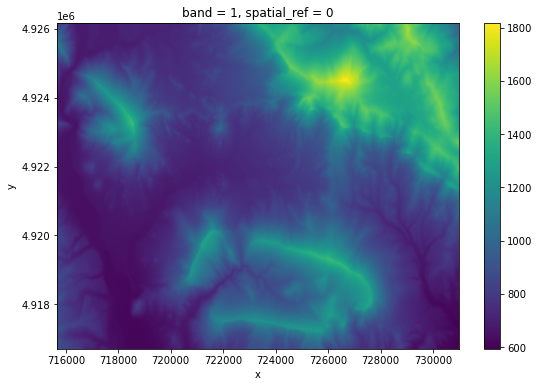

In [6]:
from os.path import join as pjoin
import pandas as pd
import numpy as np
import xarray as xr
import xrspatial as xrs
import rioxarray
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns


data_dir = '../data'         # relative path to the input data
scratch_dir = '../scratch'   # relative path to the output data.

# read and plot the data
dem = rioxarray.open_rasterio(pjoin(data_dir, "dem.tif")).squeeze() 
dem.plot(figsize=(9,6))

print ('crs = ', dem.rio.crs)
print ('nr cols, nr rows = ', dem.rio.width, dem.rio.height)
print ('xmin, ymin, xmax, ymax = ', dem.rio.bounds())

# write the data to file in the scratch directory
dem.rio.to_raster(pjoin(scratch_dir, 'dem_out.tif'))

An overview of the `dem` is obtained by simply typing the variable name. It provides the data type (DataArray), coordinates with the dimensions and the spatial reference. Note that the layered cilinder on the right of the coordinates are expandable.

In [9]:
dem

<xarray.DataArray (y: 1895, x: 3065)>
array([[832.4293 , 830.6872 , 828.9995 , ..., 971.5688 , 970.3875 , 969.2219 ],
       [833.7491 , 832.1037 , 830.5921 , ..., 971.9049 , 970.7319 , 969.58813],
       [835.1948 , 833.77124, 832.4583 , ..., 972.2599 , 971.1036 , 969.9869 ],
       ...,
       [892.69434, 891.4918 , 890.22253, ..., 597.469  , 597.4671 , 597.4556 ],
       [892.7596 , 891.4594 , 890.0948 , ..., 597.256  , 597.2413 , 597.2349 ],
       [892.76953, 891.38574, 889.93823, ..., 597.0923 , 597.0565 , 597.0371 ]],
      dtype=float32)
Coordinates:
    band         int32 1
  * x            (x) float64 7.157e+05 7.157e+05 7.157e+05 ... 7.31e+05 7.31e+05
  * y            (y) float64 4.926e+06 4.926e+06 ... 4.917e+06 4.917e+06
    spatial_ref  int32 0
Attributes:
    SourceBandIndex:         0
    STATISTICS_COVARIANCES:  60223.97714605515
    STATISTICS_MAXIMUM:      1818.408203125
    STATISTICS_MEAN:         931.67042975825
    STATISTICS_MEDIAN:       nan
    STATISTICS_MINIMUM:      593.40081787109
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       245.40573983926
    _FillValue:              -3.4028230607370965e+38
    scale_factor:            1.0
    add_offset:              0.0

# Raster analysis
The terrain date are hard to interpret by looking at the elevation only. Meaningful terrain characteristics highlight different aspects of the terrain, such as slope and aspect (orientation of the slope), or simplify interpretation of the terrain. These raster analysis functions are typical for GIS software (e.g. QGIS, ArcGIS, PCRaster) and are also available in xarray-spatial.

In [11]:
# calculate derived attributes from the digital elevation model
slope = xrs.slope(dem)
aspect = xrs.aspect(dem)
hillshade = xrs.hillshade(dem, angle_altitude=45, azimuth=225)
observer_x, observer_y = 724000, 4918000
viewshed = xrs.viewshed(dem, x=observer_x, y=observer_y, observer_elev=1.8)

# write output to scratch directory to open in QGIS
slope.rio.to_raster(pjoin(scratch_dir, 'slope.tif'))
aspect.rio.to_raster(pjoin(scratch_dir, 'aspect.tif'))
hillshade.rio.to_raster(pjoin(scratch_dir, 'hillshade.tif'))
viewshed.rio.to_raster(pjoin(scratch_dir, 'viewshed.tif'))

Text(0.5, 1.0, 'Viewshed from 724000, 4918000')

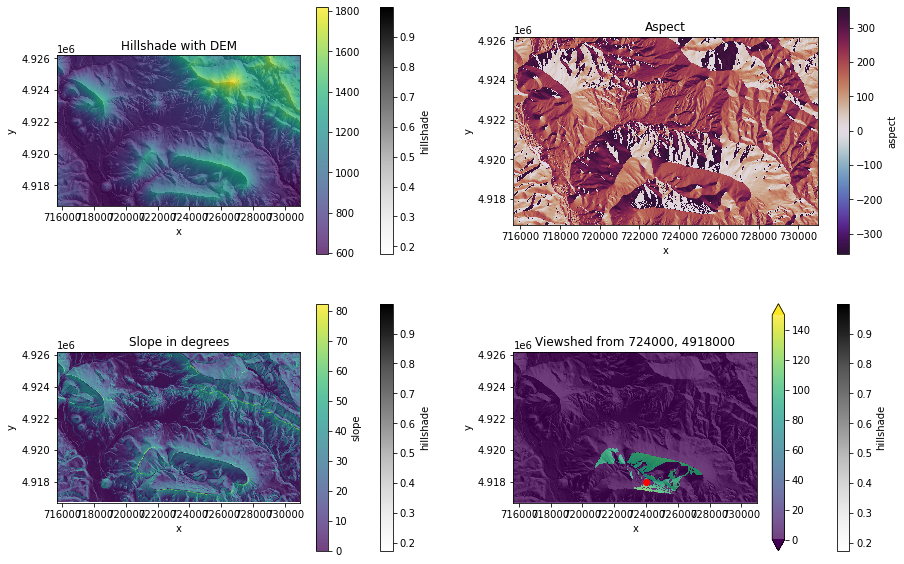

In [4]:
## visualize the data
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2,2, figsize=(15,10))

# hillshade
ax1.set_aspect('equal')
hillshade.plot(ax=ax1, cmap='Greys')
dem.plot(ax=ax1, alpha=0.75)
ax1.set_title('Hillshade with DEM')

# aspect
ax2.set_aspect('equal')
aspect.plot(ax=ax2, cmap='twilight_shifted')
ax2.set_title('Aspect')

# slope
ax3.set_aspect('equal')
hillshade.plot(ax=ax3, cmap='Greys')
slope.plot(ax=ax3, alpha=0.75)
ax3.set_title('Slope in degrees')

# viewshed
ax4.set_aspect('equal')
hillshade.plot(ax=ax4, cmap='Greys')
viewshed.plot(ax=ax4, cmap='viridis', alpha=0.75, vmin=0, vmax=150)
ax4.scatter(observer_x, observer_y, c='r')
ax4.set_title(f'Viewshed from {observer_x}, {observer_y}')

## Exercise 1 
The combination of different raster layers enables you to find the answers to specific spatial questions. Assume you are a rock climber standing at easting 721319 and northing 4921949. 

**Question 1** 

1. What is the slope in degrees of the steepest slope you can observe from this position?
2. Rock climbers also climb overhangs with slopes that exceed 90 degrees. Can overhangs be represented in 2D raster data?

**Challenge**
Extract the location of the steepest slope. Hint: use 'nanmax' on the viewshed slope data array, or a combination of 'argmax' and 'isel' to get the coordinates of the steepest visible slope. Export the location to a raster or vector file with a the spatial reference. Visualize in the notebook and confirm your answer using visualization in QGIS.

The steepest slope in sight has a values of 80.78018 degrees


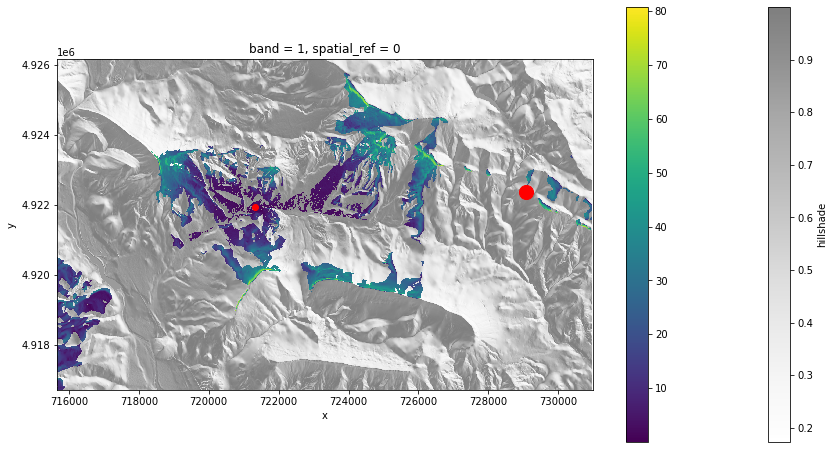

In [12]:
## Note: to be moved to answer model
from shapely.geometry import Point

# Answer to question 1.1 code
observer_x, observer_y = 721319, 4921949
viewshed = xrs.viewshed(dem, x=observer_x, y=observer_y, observer_elev=1.6)
slopes_in_sight = np.where(viewshed.data > 0, slope.data, np.nan)
max_slope_in_sight_value = np.nanmax(slopes_in_sight)
print('The steepest slope in sight has a values of', max_slope_in_sight_value, 'degrees')

# Answer to question 1.1 text
# a) the maximum slope is 80.78 degrees
# b) No, continuous raster data can not represent overhangs, or even vertical slopes.
#    The slope is calculated over the distance between two raster cells. 

# Answer to challenge:
# To check, export the visible slopes and the maximum slope to tif files and open in QGIS

# In raster format: 
# Note that you need to zoom in a lot before you see the single cell that represents the steepest visible slope.
slopes_in_sight_xr = xr.DataArray(slopes_in_sight, coords=dem.coords, dims=dem.dims)
slopes_in_sight_xr.rio.to_raster(pjoin(scratch_dir, 'slopes_in_sight.tif'))
steepest_visible_slope_loc = slopes_in_sight == max_slope_in_sight_value
steepest_visible_slope_loc = steepest_visible_slope_loc.astype('int')
steepest_visible_slope_xr = xr.DataArray(steepest_visible_slope_loc, coords=dem.coords, dims=dem.dims)
steepest_visible_slope_xr.rio.to_raster(pjoin(scratch_dir, 'steepest_visible_slope_in_sight.tif'))

# In vector format
# use argmax to get the indices of the maximum along the x and y dimensions
index_dict = slopes_in_sight_xr.fillna(1).argmax(dim=['x', 'y'])

# get the coordinates of the maximum and convert to a geodataframe
coord_da = slopes_in_sight_xr.isel(index_dict)
# df_max = coord_da.to_dataframe(name='max_slope')
geodata = {'geometry': Point(coord_da.coords['x'], coord_da.coords['y']),
           'x': coord_da.coords['x'].values,
           'y': coord_da.coords['y'].values,
           'max_slope': max_slope_in_sight_value}
gdf_max = gpd.GeoDataFrame(geodata, index=[0])
gdf_max.crs = dem.spatial_ref.crs_wkt
gdf_max.to_file(pjoin(scratch_dir, 'max_slope.geojson'), driver='GeoJSON')

# visualize to comparte to QGIS
fig, ax = plt.subplots(1,1, figsize=(15,8))
ax.set_aspect('equal')
hillshade.plot(ax=ax, alpha=0.5, cmap='Greys')
slopes_in_sight_xr.plot(ax=ax)
gdf_max.plot(ax=ax, markersize=200, facecolor='r')
ax.scatter(observer_x, observer_y, c='r')

# Stacking and clipping satellite data
The second example uses Landsat multispectral data. These images consist of separate files for each of the bands.
Look at [NASA's Landsat band description](https://landsat.gsfc.nasa.gov/satellites/landsat-8/landsat-8-bands/) for the reason for inclusion of these bands in the Operational Land Imager (OLI).

**Question 2** 
1. Which spectral band is used for vegetation health mapping
2. Which bands can distinguish wet soil from dry soil?

Load the band description from disk. Note only 30 m resolution bands are listed, so no thermal infrared and panchromatic bands. 

In [13]:
ls_bands = pd.read_csv(pjoin(data_dir, 'Landsat_bands.csv'))
# wavelength (wl) in nanometer. Given for the minimum, maximum and midpoint of the spectral bands
ls_bands

band  wl_min_nm  wl_max_nm  wl_mid_nm                label
0   B1        435        451      443.0  Coastal_and_aerosol
1   B2        452        512      482.0                 Blue
2   B3        533        590      561.5                Green
3   B4        636        673      654.5                  Red
4   B5        851        879      865.0                  NIR
5   B6       1566       1651     1608.5                SWIR1
6   B7       2107       2294     2200.5                SWIR2

The storage of the bands in separate files precludes visualizing the data as multispectral band combinations in QGIS. Therefore the band have to be stacked, i.e. combined in a single multiband geotiff. This can be done by loading the different bands in an xarray DataSet and save the DataSet to disk. The function `stack_landsat_bands` below loads the bands into separate variables in an xarray DataSet. This enables writing to a stacked tif file with the full description of the band names. If you read the stacked image from disk again, the bands are read into an xarray DataArray and not in a DataSet. The band names are now stored as a tuple in the long_name attribute.

Run the cell below and open the stacked image in QGIS.

**Question 3**  Does the `long_name` attribute of the xarray DataArray match the band names in QGIS?

Writing stacked bands to ../scratch\LS_stacked_2015.tif


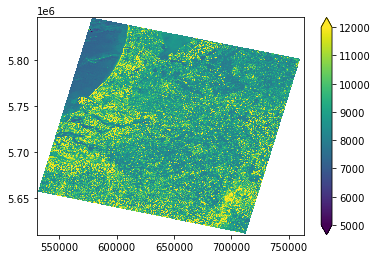

In [14]:
# create helper function 
def stack_landsat_bands(band_path_template, out_path, bands, labels):
    """Read the 30 m resolution files from disk and output with band names in long_format.
    band_path: f-string of the path to the bands on disk. {band} should contain the band number
    out_path:  path to the new output file
    bands:     iterable of the band, e.g. [B2,B3]
    labels:    iterable of long format names of the bands, e.g. ['blue', 'green']
    """
    # initiate the dataset
    ds = xr.Dataset()
    
    # load the dataset with the bands
    for band, label in zip(bands, labels):
        band_path = band_path_template.replace('BANDX', band)
        #print('Data read from', band_path)
        band_x = rioxarray.open_rasterio(band_path, mask_and_scale=True).squeeze()
        ds[label] = band_x
    
    # write to disk
    print('Writing stacked bands to', out_path)
    ds.rio.to_raster(out_path, compress='LZW', tiled=True)

#ls_2015.close() # for rerunning the cell
path_template = '../data/L8_OLI_2015_L2/LC08_L2SP_198024_20150803_20200908_02_T1_SR_BANDX.tif'
stack_landsat_bands(path_template, pjoin(scratch_dir, 'LS_stacked_2015.tif'), ls_bands.band, ls_bands.label)

ls_2015 = rioxarray.open_rasterio(pjoin(scratch_dir, 'LS_stacked_2015.tif'), mask_and_scale=True)
fig, ax = plt.subplots(1,1)
ls_2015[3].plot(ax=ax, vmin=5000, vmax=12000, add_labels=False)

This dataset covers the largest part of the South of the Netherlands. To reduce the computation time for this practical, we will limit the extent of the Landsat image using rioxarray's function [`clip_box`](https://corteva.github.io/rioxarray/stable/examples/clip_box.html#). This function takes the bounding box coordinates in the same spatial reference as the original data set. 

C:\Users\straa005\Anaconda3\envs\sml\lib\site-packages\rasterio\windows.py:310: RasterioDeprecationWarning: The height, width, and precision parameters are unused, deprecated, and will be removed in 2.0.0.
  warnings.warn(


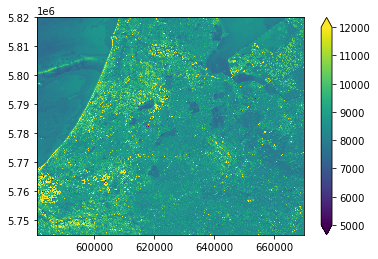

In [15]:
xmin, xmax, ymin, ymax = 580750, 670000, 5745000, 5820000
ls_2015_clip = ls_2015.rio.clip_box(minx=xmin, miny=ymin, maxx=xmax, maxy=ymax)
ls_2015_clip.rio.to_raster(pjoin(scratch_dir, 'ls_2015_clip.tif'), compress='LZw')

ls_2015_clip[1].plot(vmin=5000, vmax=12000, add_labels=False)

**Question 4** How much smaller is the clipped image in number of cells and as a fraction?

In [16]:
# Answer
rows_clip, cols_clip = ls_2015_clip.data.shape[1:]
rows_full, cols_full = ls_2015.data.shape[1:]
reduction_fraction = (rows_clip * cols_clip) / (rows_full * cols_full)
reduction_nr_cells = (rows_full * cols_full) - (rows_clip * cols_clip)
print(f'The number of cells is reduced by a fraction of {reduction_fraction}')
print(f'The reduction in number of cells is {reduction_nr_cells}')

# Note that this will speed up operations by a factor 8

The number of cells is reduced by a fraction of 0.12106577064369575
The reduction in number of cells is 54035805



# Visualizing multispectral images
 

Now that we have a manageable multispectral images, we can explore remote sensing data visualization. A good first impression is to plot the data of all bands individually using xarray's `imshow`.

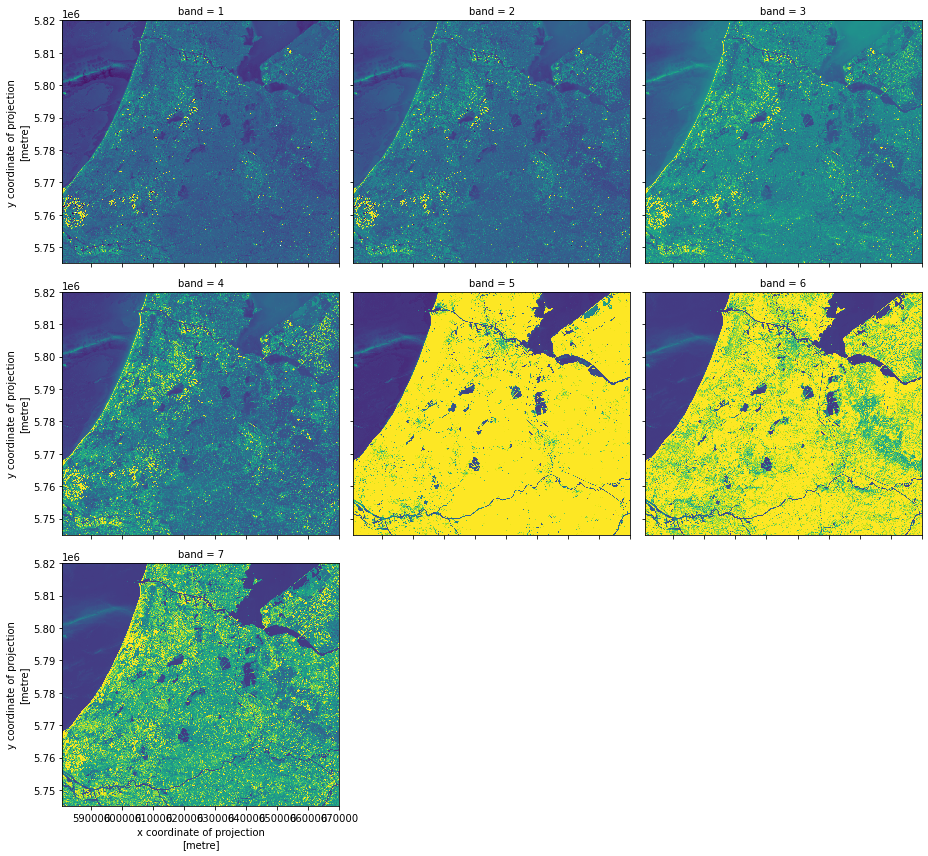

In [10]:
ls_2015 = ls_2015_clip.copy() # work with the clipped data.

ls_2015.plot.imshow(col='band', col_wrap=3, vmin=6000, vmax=14000,
                    size=4, aspect=1,
                    add_labels=True,
                    add_colorbar=False) # needed due to bug in plot function (2022)
plt.savefig(pjoin(scratch_dir, 'bands.jpg'))

There are many interesting and useful components to note from this figure:
1. Band 5 (Near Infrared) shows a much higher reflectivity than the visual bands (1-4) and short wave infrared bands (6-7).
2. Water has a lowest reflectivity in all bands
3. The highest reflectivity values in all bands (set `vmax=30000`) are found in the western part.
4. The land-water boundary along the coast shows up as a very crips line in band 5 compared to band 3.

**Question 5** What land land cover has the highest reflectivity values? Use Google Earth to get independent confirmation.

In [11]:
# Answer: Greenhouses with glass roofs show up extremely high. 
# Fun fact: in a global land cover classification, it was mistaken for a glacier.

A more complete overview of the data comes from: band combinations, the histogram, the feature space and the spectral profile. Here, we will look at each of these options. Run the cell below.

0 Coastal_and_aerosol
1 Blue
2 Green
3 Red
4 NIR
5 SWIR1
6 SWIR2


Text(0.5, 0, 'Red - band 4')

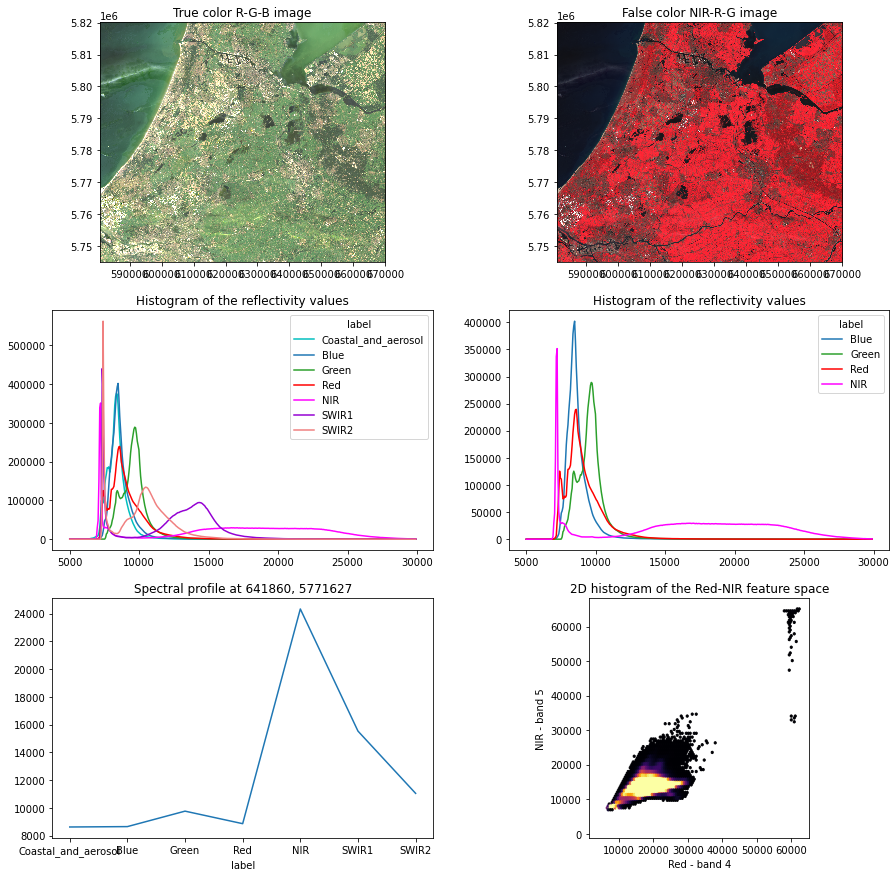

In [12]:
ls_2015 = ls_2015_clip.copy() # work with the clipped data.

fig, [[ax1, ax2], [ax3, ax4], [ax5, ax6]] = plt.subplots(3,2, figsize=(15,15))

# True color RGB
ls_2015[1:4,:,:][::-1].plot.imshow(ax=ax1, rgb='band', vmin=6000, vmax=12000, add_labels=False)
ax1.set_title('True color R-G-B image')
ax1.set_aspect('equal')

# False color image
ls_2015[2:5,:,:][::-1].plot.imshow(ax=ax2, rgb='band', vmin=6000, vmax=24000, add_labels=False)
ax2.set_title('False color NIR-R-G image')
ax2.set_aspect('equal')

# Histogram 7 bands
bands = ls_bands.label
bins = np.arange(5000, 30000, 60)
hist_data = {}
for i, band in enumerate(bands):
    print(i, band)
    hist_data[band] = np.histogram(ls_2015[i:i+1,:,:].data, bins=bins, range=(1,30000))[0]
hist_df = pd.DataFrame(hist_data, columns=bands, index=bins[0:-1])
hist_df.plot.line(ax=ax3,
                  color=['c', 'tab:blue', 'tab:green', 'r', 'magenta', 'darkviolet', 'lightcoral'])
ax3.set_title('Histogram of the reflectivity values')

# Histogram 4 bands
hist_df.iloc[:,1:5].plot.line(ax=ax4,
                              color=['tab:blue', 'tab:green', 'r', 'magenta'])
ax4.set_title('Histogram of the reflectivity values')

# Spectral profile
xcoord, ycoord = 641860, 5771627 
profile_da = ls_2015.sel(x=xcoord, y=ycoord, method='nearest')
profile_df = profile_da.to_dataframe(name='spectral values').set_index(bands)
profile_df['spectral values'].plot.line(ax=ax5)
ax5.set_title(f'Spectral profile at {xcoord}, {ycoord}')

# Feature space
hb = ax6.hexbin(ls_2015[4], ls_2015[5],
           vmax=10000, mincnt=5,
           cmap='inferno')
ax6.set_aspect('equal')
ax6.set_title('2D histogram of the Red-NIR feature space')
ax6.set_ylabel('NIR - band 5')
ax6.set_xlabel('Red - band 4')

## Exercise 2
The data folder contains a second Landsat image, which was collected in 2020 (../data/L8_OLI_2020_L2). Carry out the following steps:
- Stack the bands of the 2020 image and write to a separate file, e.g.'LS_stacked_2020.tif'.
- Clip the image to the same extent as the 2015 image and save to 'LS_2020_clip.tif' 
- Open both images in QGIS.
- Visualize the images as multiband image in true-color R-G-B and as false-color NIR-R-G.
- Zoom to the following locations in QGIS and inspect the changes between 2015 and 2020.

| Location             | Easting  | Northing |
|----------------------|---------:|---------:|
| Utrecht-west         | 641860   | 5771627  |
| Hilversum-south      | 649625   | 5785787  |
| Oostvaardersplassen  | 657599   | 5813391  |
| Flevoland polder     | 664715   | 5802513  |

**Question 5** 
1. What changes in spectral values have occurred in these location? Use the 'Identify Features' tool (ctrl-shft-i). In the 'Identify results' panel, set Mode to Top Down, and View to Graph. to jointly visualize the band values.
2. Which of these changes in spectral values are due to land cover changes? You can use OpenStreetmap or Google Earth as reference.

**Challenge** Write a script to visualize the spectral profiles for each of these locations in both years. Use the band means of the landsat bands on the x-axis. Hints:
- to extract values at specific coordinates in the xarray DataSet, you can use '.sel'.
- use seaborn's relplot for plotting the relation between band wavelength and reflectivity.

In [13]:
ls_2020 = rioxarray.open_rasterio(pjoin(scratch_dir, 'LS_stacked_2020.tif'))
ls_2020_clip = ls_2020.rio.clip_box(minx=xmin, miny=ymin, maxx=xmax, maxy=ymax)
ls_2020_clip.rio.to_raster(pjoin(scratch_dir, 'ls_2020_clip2.tif'), compress='LZw')


C:\Users\straa005\Anaconda3\envs\sml\lib\site-packages\rasterio\windows.py:310: RasterioDeprecationWarning: The height, width, and precision parameters are unused, deprecated, and will be removed in 2.0.0.
  warnings.warn(


Writing stacked bands to ../scratch\LS_stacked_2020.tif


C:\Users\straa005\Anaconda3\envs\sml\lib\site-packages\rasterio\windows.py:310: RasterioDeprecationWarning: The height, width, and precision parameters are unused, deprecated, and will be removed in 2.0.0.
  warnings.warn(
C:\Users\straa005\Anaconda3\envs\sml\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


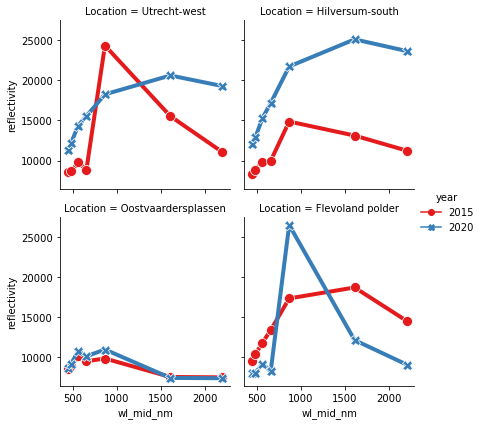

In [14]:
## To be moved to the answer section
ls_2020.close()
ls_2020_clip.close()
from shapely.geometry import Point

# answer Exercise 2:
# Apply to stack_landsat_bands function to the 2020 data set
path_template = '../data/L8_OLI_2020_L2/LC08_L2SP_198024_20200731_20200908_02_T1_SR_BANDX.TIF'
stack_landsat_bands(path_template, pjoin(scratch_dir, 'LS_stacked_2020.tif'), ls_bands.band, ls_bands.label)
ls_2020 = rioxarray.open_rasterio(pjoin(scratch_dir, 'LS_stacked_2020.tif'))
ls_2020_clip = ls_2020.rio.clip_box(minx=xmin, miny=ymin, maxx=xmax, maxy=ymax)
ls_2020_clip.rio.to_raster(pjoin(scratch_dir, 'ls_2020_clip.tif'), compress='LZw')


# Changes per location:
#     Utrecht-west, change in land cover from meadow to bare earth due to the building site for housing of Leidsche Rijn
#     Hilversum-south, change in land cover from paved to bare earth after road removal
#     Oostvaardersplassen, no change in land cover, but increase in reflectivity due to algea or sediment
#     Flevoland polder, change in land cover from bare to crop, but no change is land use. Both are agricultural land use.

# Challenge
import seaborn as sns

ls_2015 = rioxarray.open_rasterio(pjoin(scratch_dir, 'LS_2015_clip.tif'))
ls_2020 = rioxarray.open_rasterio(pjoin(scratch_dir, 'LS_2020_clip.tif'))


locs = {'Location': ['Utrecht-west', 'Hilversum-south', 'Oostvaardersplassen', 'Flevoland polder'],
        'Easting': [641860, 649625, 657599, 664715],
        'Northing': [5771627, 5785787, 5813391, 5802513]
       }
locs_df = pd.DataFrame(locs)

# write points to geojson file for comparison in QGIS.
locs_gdf = gpd.GeoDataFrame(locs_df.copy())
locs_gdf['geometry'] = locs_gdf.apply(lambda row: Point(row.Easting, row.Northing), axis=1)
locs_gdf.crs = ls_2015.spatial_ref.crs_wkt
locs_gdf.to_file(pjoin(scratch_dir, 'locs_profiles.geojson'), driver='GeoJSON')

# set up the output dataframe
result = pd.concat([locs_df, locs_df], axis=0)
result['year'] = 4 * [2015] + 4 * [2020]
result = result.reset_index(drop=True)


# compile the spectral profiles and join with results
profiles = []
band_names = ls_bands.label
da_dict = {2015: ls_2015,
           2020: ls_2020}

for location, x, y, year in result.values:
#     print(location, x, y, year)
    da = da_dict[year]
    prof = da.sel(x=x, y=y, method='nearest')
    profiles.append(prof)
profiles_df = pd.DataFrame(data = np.vstack(profiles), columns=band_names)
result = result.join(profiles_df)

# make a tidy dataframe
tidy = result.copy()
tidy = pd.melt(tidy, id_vars=['Location', 'year'], var_name='band_name', value_name='reflectivity')
tidy = tidy.merge(ls_bands, left_on='band_name', right_on='label')

# vizualize using seaborn
sns.relplot(data=tidy, 
            x='wl_mid_nm', y='reflectivity', # change to x='band_name' for labelled x axis
            kind='line', hue='year', palette='Set1', linewidth=4,
            markers=True, markersize=10, style='year', dashes=False,
            col='Location', col_wrap=2,
            height=3)


# Spectral ratioing

Spectral ratioing refers to enhancement techniques by combining pixel values from different spectral bands. Ratio images are prepared by dividing the digital numbers in one band by the corresponding digital numbers in another band. The most widely used ratio techniques are ratios to enhance the vegetation cover or to distinguish bare soil from vegetation. Most vegetation indices combine one infrared spectral band with one visible band. 

Vegetation indices are often used to estimate from remote sensing images the leaf area index, the vegetation cover or the biomass for specific areas. Although there is a correlation between biomass, leaf area index, vegetation cover and spectral vegetation indices, some caution is necessary. The relations between spectral indices and these vegetation properties is often area-specific (that means that functions developed in one study area cannot be used directly in other areas), the condition of the soil and the type of soil beneath the vegetation or crop has a certain impact on the value of the spectral indices: although the vegetation cover remains the same, the value of the spectral index might change due to a change in underlying soil. Some vegetation indices take soil condition into account using information from the SWIR bands.

Spectral indices used for these purposes are e.g.:

|Vegetation index|Formula|
|------------|---------------|
|Simple ratio (SR)| SR = NIR / R|
|Normalized difference vegetation index (NDVI)|NDVI = (NIR–R) / (NIR+R)|
|Perpendicular vegetation index (PVI)| PVI = (NIR-aR-b) / (a<sup>2</sup>+1)<sup>½</sup>|
|Soil adjusted vegetation index (SAVI)| SAVI = (NIR–R) / (NIR+R+L)(1+L) |
|Transformed soil adjusted vegetation index (TSAVI)| TSAVI = a(NIR-aR-b) / (R+a(NIR-b)+X(1+a<sup>2</sup>)) |
|Modified normalized difference vegetation index (MNDVI)| MNDVI = NDVI * (SWIR<sub>max</sub> – SWIR) / (SWIR<sub>max</sub>–SWIR<sub>min</sub>) |
|Enhanced vegetation index (EVI)| EVI = 2.5*((NIR–R) / (NIR + 6R - 7.5B + 1)) |
|Reduced simple ratio (RSR)| RSR = SR * (SWIR<sub>max</sub>–SWIR) / (SWIR<sub>max</sub>–SWIR<sub>min</sub>) |
|Moisture adjusted vegetation index (MAVI)| MAVI = (NIR–R) / (NIR+R+SWIR)|

Where B, R, NIR, and SWIR are the surface reflectance in the blue, red, near infrared, and shortwave infrared bands, respectively. SWIR<sub>max</sub> and SWIR<sub>min</sub> are the maximum and minimum surface reflectance in the SWIR band, respectively. SWIR<sub>max</sub> and SWIR<sub>min</sub> are defined as the 1% minimum and maximum cutoff points in the histogram of the SWIR band reflectance here. a and b are the slope and intercept of the soil line, respectively. L, X, Y, and Z are soil background adjusted factors. c is an atmospheric self-correcting factor which depends on aerosol types.

from [https://doi.org/10.1371/journal.pone.0102560](https://doi.org/10.1371/journal.pone.0102560)

The code below gives and example.

NDVI values for 2015 and 2020:  0.1288822400728479 0.5250064709096661


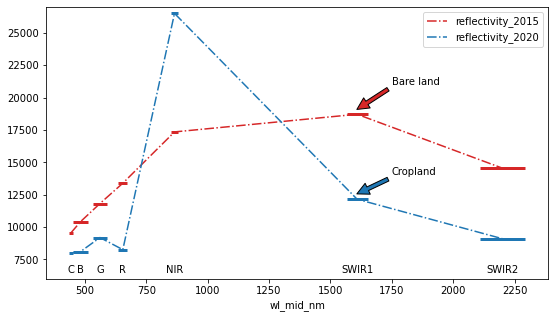

In [15]:
# starting with the spectral profiles of the polder in Flevoland
# constract the DataFrame
sp = {'band': {1: 'C', 0: 'B', 2: 'G', 4: 'R', 3: 'NIR', 5: 'SWIR1', 6: 'SWIR2'}, 
      'wl_min_nm': {1: 435, 0: 452, 2: 533, 4: 636, 3: 851, 5: 1566, 6: 2107}, 
      'wl_mid_nm': {1: 443.0, 0: 482.0, 2: 561.5, 4: 654.5, 3: 865.0, 5: 1608.5, 6: 2200.5}, 
      'wl_max_nm': {1: 451, 0: 512, 2: 590, 4: 673, 3: 879, 5: 1651, 6: 2294}, 
      'reflectivity_2015': {1: 9549.0, 0: 10415.0, 2: 11825.0, 4: 13393.0, 3: 17356.0, 5: 18720.0, 6: 14553.0}, 
      'reflectivity_2020': {1: 7998.0, 0: 8103.0, 2: 9195.0, 4: 8258.0, 3: 26513.0, 5: 12156.0, 6: 9103.0}}

df = pd.DataFrame(sp)
df.index = df.band

# plot the spectral profiles
fig, ax = plt.subplots(1,1, figsize=(9,5))
ax.hlines(df.reflectivity_2015, df.wl_min_nm, df.wl_max_nm, color = 'tab:red', linewidth=3)
ax.hlines(df.reflectivity_2020, df.wl_min_nm, df.wl_max_nm, color = 'tab:blue', linewidth=3)
df.plot.line('wl_mid_nm', 'reflectivity_2015', style=['-.'], color='tab:red', ax=ax)
df.plot.line('wl_mid_nm', 'reflectivity_2020', style=['-.'], color='tab:blue', ax=ax)
for band, wl in zip(df.band, df.wl_mid_nm):
    ax.text(wl, 6500, band, horizontalalignment='center')
_ = ax.annotate('Cropland', xy = (1600, 12500), xytext=(1750,14000), arrowprops=dict(facecolor='tab:blue', shrink=0.05))
_ = ax.annotate('Bare land', xy = (1600, 19000), xytext=(1750,21000), arrowprops=dict(facecolor='tab:red', shrink=0.05))
ax.set_ylim(6000, 27000)

# calculate and prit the NDVI for both years
def NDVI(Red, NIR):
    return (NIR - Red) / (NIR + Red)

ndvi_2015 = NDVI(df.loc['R', 'reflectivity_2015'], df.loc['NIR', 'reflectivity_2015'])
ndvi_2020 = NDVI(df.loc['R', 'reflectivity_2020'], df.loc['NIR', 'reflectivity_2020'])

print('NDVI values for 2015 and 2020: ', ndvi_2015, ndvi_2020)


The spectral profiles above show the change from bare land in 2015 to cropland in 2020. The bare land has higher values in the red band and lower values in near infrared when compared to cropland. This leads to a lower NDVI for bare land than for cropland.

The same function can be used to calculate the NDVI for a whole multispectral image. The simplest method is to select the proper bands from the data array and do the band math in numpy. However, in this case the metadata with the crs are lost and saving to disk becomes more complicated. Therefore, we will use an expanded version to work with xarray.

In [18]:
def NDVI_da(da, red_band_nr, nir_band_nr):
    """
    Calculate the Normalized Difference Vegetation Index from an xarray data array.
    da: xarray DataArray, with multispectral data in bands. Numbering starts at 1.
    red_band_nr: int, band number of the red band
    nir_band_nr: int, band number of the nir band
    
    Returns a DataArray with a single band representing the NDVI
    """
    red = da[red_band_nr - 1]
    nir = da[nir_band_nr - 1]
    ndvi = (nir - red) / (nir + red)
    ndvi.attrs['long_name'] = ('NDVI')
    return ndvi


ls_2015 = rioxarray.open_rasterio(pjoin(scratch_dir, 'LS_2015_clip.tif'))
ls_2020 = rioxarray.open_rasterio(pjoin(scratch_dir, 'LS_2020_clip.tif'))
ndvi_2015 = NDVI_da(ls_2015, 4, 5)
ndvi_2020 = NDVI_da(ls_2020, 4, 5)
ndvi_2015.rio.to_raster(pjoin(scratch_dir, 'ndvi_2015.tif'), compress='LZW')
ndvi_2020.rio.to_raster(pjoin(scratch_dir, 'ndvi_2020.tif'), compress='LZW')
ndvi_2015.close()

**Question 6** Open the NDVI image of 2015 in QGIS. What is are typical values of NDVI for forest, crops, bare earth and builtup areas?

Answer question 6:
* Forest: around 0.3
* Crops: around 0.4
* Bare earth: around 0
* Builtup areas: around 0.05

## Exercise 3

Create a new function to calculate the Enhance Vegetation Index based on the `NDVI_da` function defined above. Calculate the NDVI and EVI for 2015 and 2020 and write them to disk. Open in QGIS. Note that the EVI has large outliers, so you need to limit the range of values between 0 and 4 to see a meaningful pattern. 

**Question 7** Compare the NDVI and EVI values for the following places
1. Surfzone along the coast.
2. Cropland vs forest. Is the EVI higher for forest or for cropland? Is the NDVI higher or lower for cropland than for forest?
3. Zoom in on Amsterdam. Which index show the the least noise?
4. Based on these observations, which index do you prefer to characterize vegetation? Motivate your choice

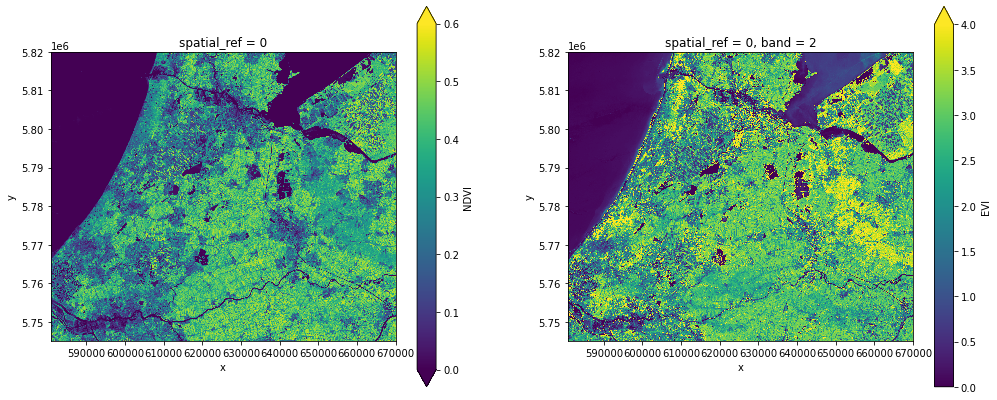

In [50]:
# answer to question 7

def EVI_da(da, blue_band_nr, red_band_nr, nir_band_nr):
    """
    Calculate the Moisture Adjusted Vegetation Index from an xarray data array.
    da: xarray DataArray, with multispectral data in bands. Numbering starts at 1.
    blue_band_nr: int, band number of the blue band
    red_band_nr: int, band number of the red band    
    nir_band_nr: int, band number of the nir band
    
    Returns a DataArray with a single band representing the NDVI
    """
    blue = da[blue_band_nr - 1]
    red = da[red_band_nr - 1]
    nir = da[nir_band_nr - 1]
    evi = 2.5 * (nir - red) / (nir + 6*red - 7.5*blue + 1)
    evi.attrs['long_name'] = ('EVI')
    #limit values between 0 and 7
    evi_max = np.maximum(evi, 0)
    evi_min_max = np.minimum(evi_max, 7)
    return evi_min_max

ls_2015 = rioxarray.open_rasterio(pjoin(scratch_dir, 'LS_2015_clip.tif'))
ndvi_2015 = NDVI_da(ls_2015, 4, 5)
evi_2015 = EVI_da(ls_2015, 2, 4, 5)

ndvi_2015.rio.to_raster(pjoin(scratch_dir, 'ndvi_2015.tif'), compress='LZW')
evi_2015.rio.to_raster(pjoin(scratch_dir, 'evi_2015.tif'), compress='LZW')

fig, [ax0, ax1] = plt.subplots(1,2, figsize=(17,7))
ndvi_2015.plot(ax=ax0, vmin=0, vmax=0.6, cmap='viridis')
ax0.set_aspect('equal')
evi_2015.plot(ax=ax1, vmin=0, vmax=4, cmap='viridis')
ax1.set_aspect('equal')

# # Answers
# 1. The seaward side of the surfzone shows increasing EVI values and decreasing NDVI values. 
# 2. For the EVI forest is higher than cropland. For NDVI it is the other way around
# 3. The EVI shows a noisy pattern for Amsterdam with very high values neighbouring low ones.
# 4. Looking just at the vegetation, the range in values between forest, meadows and cropland is larger for EVI, 
#    which means less overlap between the different classes. For that purpose, EVI works better

# Homogenisation through mosaicking, reprojecting and resampling
Raster data sets often have different projections, resolutions and extent. If you want to analyse combinations of these sets, the data need to be homogenised, which means that the data need to have the same, projection, extent and cell size. Here, we will go through the steps to homogenize two datasets in order to determine whether there is a relationship between the EVI and the terrain height in this part of the Netherlands. That means that we want to extract the mean and standard deviation of the different height intervals. This can be done with the following steps:
1. Reprojecting the satellite data to RD
2. Mosaicking a set of terrain height tiles of the national lidar campaign into a single DEM
3. Clip the dem to the extent of the satellite data
4. Reclassify the DEM into zones of terrain height intervals
5. Calculate the mean and standard deviation of the EVI for each height interval using zonal statistics.

## Reprojecting raster data

The spatial reference, or coordinate reference system (crs) for the Netherlands is called `Amersfoort` or `RD New` and you can find the details of this projection on [spatialreference.org](https://www.spatialreference.org/ref/epsg/28992/). A crs can be referred to by its EPSG code. For `RD New` the EPSG code is 28992.

Run the cell below and note that image has rotated from the reprojection. 

Text(0.5, 1.0, 'EPSG:28992')

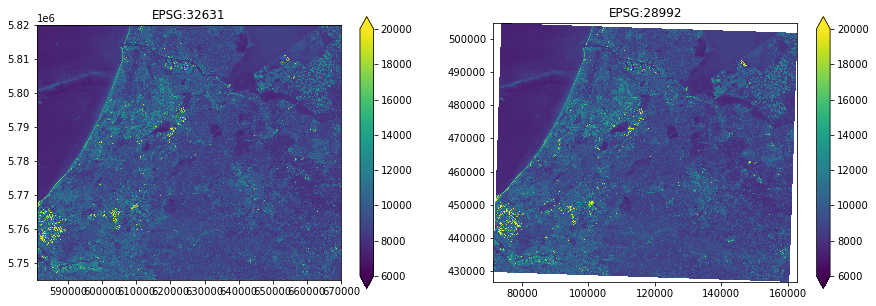

In [22]:
ls_2015 = rioxarray.open_rasterio(pjoin(scratch_dir, 'LS_2015_clip.tif'))
ls_2015_RD = ls_2015.rio.reproject("EPSG:28992")
ls_2015_RD.rio.to_raster(pjoin(scratch_dir, 'ls_2015_RD.tif'))

fig, ax = plt.subplots(1,2, figsize=(15,5))
ls_2015[3].plot(ax=ax[0], vmin=6000, vmax=20000, add_labels=False)
ax[0].set_aspect('equal')
ax[0].set_title(ls_2015.rio.crs)

ls_2015_RD[3].plot(ax=ax[1], vmin=6000, vmax=20000, add_labels=False)
ax[1].set_aspect('equal')
ax[1].set_title(str(ls_2015_RD.rio.crs))

# Mosaicking raster data
Terrain height information for the Netherlands is derived from detailed lidar campaigns. Airborn lidar is an active remote sensing system that emits laser pulses from a plane or helicopter. It determines the range to the surface below by counting the return travel time of the pulse. Combined with the position and orientation of the aircraft the surface elevation can be determined [Lemmens (2011)](https://link.springer.com/chapter/10.1007/978-94-007-1667-4_8). This open source data set is available with different spatial resolutions. For our application here, we use map tiles of 25 by 40 km with a cell length of 100 m. The rasters are stored in the [arcinfo binary grid](https://gdal.org/drivers/raster/aig.html) format, where the folder is considered the file name and the metadata is stored in the accompanying folder called 'info' (yes, really).

**Question 8** Inspect the AHN_min folder in the data directory. What are the map tiles called?

The mosaicking is carried out with the [`merge_arrays`](https://corteva.github.io/rioxarray/stable/rioxarray.html#rioxarray.merge.merge_arrays) function of `rioxarray.merge`.

**Question 9** xarray has a similar function called `xarray.combine_by_coords`. Lookup this xarray function. Why would you prefer to use merge_arrays?

C:\Users\straa005\Anaconda3\envs\sml\lib\site-packages\rasterio\windows.py:310: RasterioDeprecationWarning: The height, width, and precision parameters are unused, deprecated, and will be removed in 2.0.0.
  warnings.warn(


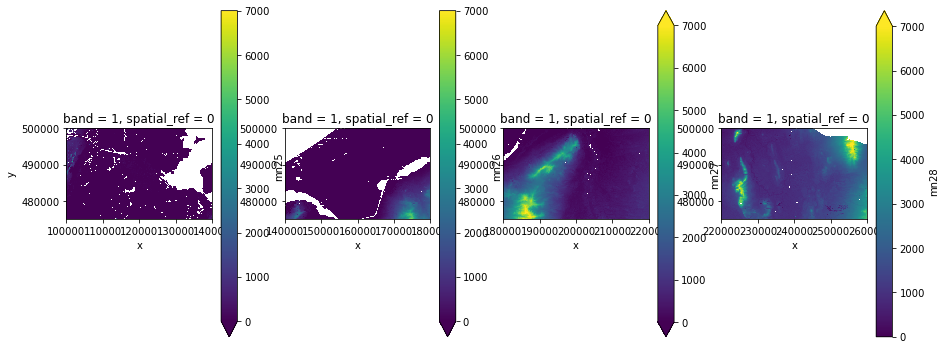

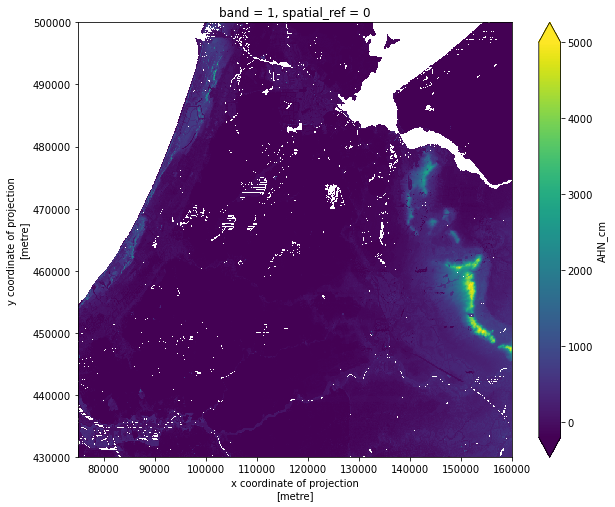

In [49]:
from rioxarray.merge import merge_arrays

def aspect_equal_axis(da):
    return da.shape[2] / da.shape[1]

# mosaic DEM
ahn_dir = pjoin(data_dir, 'AHN_min')
data_arrays = []

for map_no in np.arange(19,41,1):
    f_tile = pjoin(ahn_dir, str(map_no), 'mn' + str(map_no))
    da_tile = rioxarray.open_rasterio(f_tile, mask_and_scale=True)
    da_tile.rio.write_crs(28992, inplace=True)
    data_arrays.append(da_tile)
    ds[map_no] = da_tile
ahn_mosaic = merge_arrays(data_arrays)
ahn_mosaic.attrs['long_name'] = ('AHN_cm')
ahn_mosaic.rio.to_raster(pjoin(scratch_dir, 'ahn.tif'))

fig, [ax1,ax2,ax3,ax4] = plt.subplots(1,4, figsize=(15,6))
data_arrays[6].plot(ax=ax1, vmin=0, vmax=7000, cmap='viridis')
data_arrays[7].plot(ax=ax2, vmin=0, vmax=7000, cmap='viridis')
data_arrays[8].plot(ax=ax3, vmin=0, vmax=7000, cmap='viridis')
data_arrays[9].plot(ax=ax4, vmin=0, vmax=7000, cmap='viridis')
ax1.set_aspect('equal')
ax2.set_aspect('equal')
ax3.set_aspect('equal')
ax4.set_aspect('equal')

# Clip DEM to the clipped landsat extent in RD
xmin_RD, xmax_RD, ymin_RD, ymax_RD = 75000, 160000, 430000, 500000
ahn_clip = ahn_mosaic.rio.clip_box(minx=xmin_RD, miny=ymin_RD, maxx=xmax_RD, maxy=ymax_RD)
ahn_clip[0].plot.imshow(vmin=-200, vmax=5000,
                          size=8, aspect=aspect_equal_axis(ahn_clip))

Adjust to code to write the clipped DEM to file and open in QGIS. Note that there is a stripy pattern of missing data in the smaller water bodies.

**Question 10** What causes the stripes in missing data? Check with Lemmens (2011) for background.


# Data homogenisation

Data homogenisation is rather easy using the `reproject_match` function, which wraps gdal_warp.

C:\Users\straa005\Anaconda3\envs\sml\lib\site-packages\rioxarray\raster_writer.py:110: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


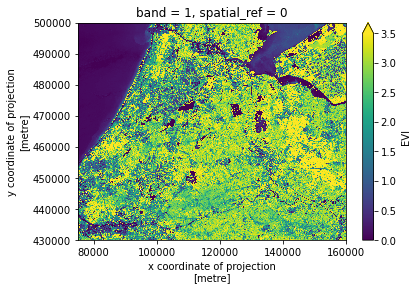

In [55]:
# Instead of the first line, you can also use your own EVI image

evi_2015 = rioxarray.open_rasterio(pjoin(data_dir, 'evi_2015.tif'))
evi_2015_RD = evi_2015.rio.reproject_match(ahn_clip)
evi_2015_RD.rio.to_raster(pjoin(scratch_dir, 'evi_2015_RD.tif'))

evi_2015_RD.plot(vmax=3.5)

**Question 11** Why is the file size of 'evi_2015_RD.tif' more than a factor 10 smaller than 'evi_2015.tif'?

# Zonal statistics
To calculate zonal statistics you need zones, which can be a polygon layer or a categorical raster. Here we reclassify the DEM into zones using `xrspatial`, which enables user-defined intervals to be assigned with new classes. 

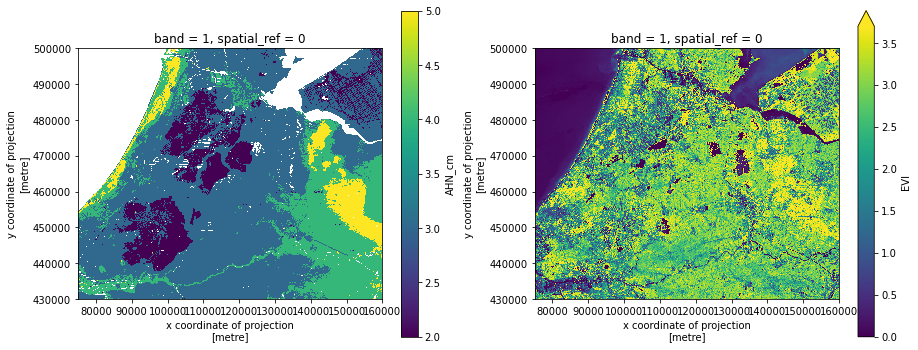

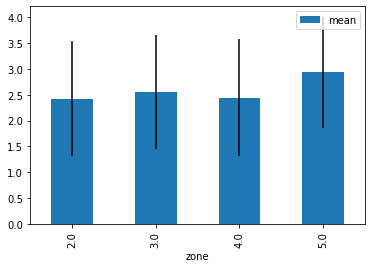

In [71]:
# Calculate the zonal statistics
from xrspatial.zonal import stats
from xrspatial.classify import reclassify

# Create height intervals
bins = [-10000, -500,  0, 500,50000]
# interval edges
ahn_zones = reclassify(ahn_clip[0], 
                       bins=bins,
                       new_values=[1,2,3,4,5],
                       name='zones')

df = stats(zones=ahn_zones, 
           values=evi_2015_RD[0])

# plot the output
fig, [ax0, ax1] = plt.subplots(1,2, figsize=(15,6))
ahn_zones.plot(ax=ax0)
ax0.set_aspect('equal')
evi_2015_RD.plot(ax=ax1, vmax=3.7)
ax1.set_aspect('equal')

df.plot.bar('zone','mean', yerr='std')

ahn_zones.rio.to_raster(pjoin(scratch_dir, 'ahn_zones.tif'))

The spatial results show category 5, with terrain heights above 500 cm along the dune field close to the coastline and on the 'Utrechtse Heuvelrug' in the East. The EVI values show a much more noisy pattern, but also a cluster of higher values in the East. The statistical analysis showed an average value of 2.9 for zone 5, which is 0.5 higher than the other zones. However, the standard deviation of all zones is larger than the difference in mean between the zones. 

## Exercise 4
Band 10 of the 2020 Landsat image. Determine the height of the Urban Heat Island effect. Rank the land cover classes of 
https://lcviewer.vito.be/download from warmest to coolest. How much warmer is the city than the water on average?